## Acoustic absorption with Perfectly Matched Layer (PML) with Finite Difference Time Domain (FDTD)

$$\partial^2_t p(x,y,t) = c^2\nabla^2p(x,y,t) + s(x,y,t),$$

where $p$ is (air) pressure and $s$ source.

If $x,y,t$ are given by indices $i,j,k$, respectively,

$$\frac{1}{c^2}\frac{\partial^2 p(x,y,t)}{\partial t^2} \approx \frac{p_{i,j}^{k-1}-2p_{i,j}^k+p_{i,j}^{k+1}}{c^2dt^2}$$

$$\frac{\partial^2 p(x,y,t)}{\partial x^2} \approx \frac{p_{i-1,j}^{k}-2p_{i,j}^k+p_{i+1,j}^{k}}{dx^2}$$

$$\frac{\partial^2 p(x,y,t)}{\partial y^2} \approx \frac{p_{i,j-1}^{k}-2p_{i,j}^k+p_{i,j+1}^{k}}{dy^2},$$

but we are not taking this path here.


It's common to split the wave equation into two first-order equations for pressure and velocity.

$$\frac{\partial\vec{v}}{\partial t} = -\frac{1}{\rho}\vec{\nabla}p$$

$$\frac{\partial p}{\partial t} = -\rho c^2 \vec{\nabla}\cdot\vec{v}.$$

Let's normalise the variables, with $\vec{v}\to\vec{v}/c$, $p\to p/(\rho c^2)$ and $t\to ct/\lambda$, where $\lambda$ is taken as the characteristic length. Then, and avoiding prime or tilde notations, which amounts to setting $c=\rho=\lambda=1$,

$$\frac{\partial\vec{v}}{\partial t} = -\vec{\nabla}p$$

$$\frac{\partial p}{\partial t} = -\vec{\nabla}\cdot\vec{v}.$$

Now, a way to implement damping, used in [this reference](https://doi.org/10.1006/jcph.1997.5868) and coming from this other [reference](https://doi.org/10.1006/jcph.1994.1159), is (in compact form, without splitting $p$)

$$\frac{\partial v_x}{\partial t} = - \frac{\partial p}{\partial x} - \sigma_x(x) v_x$$
$$\frac{\partial v_y}{\partial t} = - \frac{\partial p}{\partial y} - \sigma_y(y) v_y$$
$$\frac{\partial p}{\partial t} = - \left( \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y} \right) - \left( \sigma_x(x) + \sigma_y(y) \right) p,$$

where $\sigma$'s are the "conductivities" (PML jargon) or attenuation/damping parameters.

The goal now is to get an expression for these $\sigma_x, \sigma_y$. At the physical space (not PML), $\sigma_x=\sigma_y=0$, whereas penetrating the PML's we will get higher and higher $\sigma$'s. Typically,

$$\sigma_x = \sigma_{max}f_x^m,$$

where $m$ is optimally 3 or 4, $f_x$ the relative penetration into the PML, and where $\sigma_y$ gets a similar expression. In this [reference](https://d1wqtxts1xzle7.cloudfront.net/63242042/Electrical_Engineering_Handbook20200508-12748-1318gxz-libre.pdf?1588963584=&response-content-disposition=inline%3B+filename%3DTHE_ELECTRICAL_ENGINEERING_HANDBOOKS.pdf&Expires=1749669374&Signature=SY6dlKeuumg0axkv4-ZWL0iuYTsM5kraCNlhDf~rLonYUomz9sBvukc-0~0saE19SXjBT8Uqu-FDoygMwLM3qSOrHnnKWCKSinCRraBfi1XoYdUjBLEmOcKnpzk4729HBT8Wi8uGrqiZ1Ryp~En0dBLCrXbNuOwRSbWUb5-oxmAiz6gf6zLOxihruL5yfuIqgAgdTwehJC1azOCIBkDzjNGhLs-b8KXLXHkeoTm0IX1LGtZomJlgKc911UiAGygAWOPvdf9WHPGe1ZQLli4IorG-ykIY06387vsSmlpkZk3-HCve10IcH4aEvgOeKv0oi9tgMcjKf7e3S8l8PAKbhg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA#page=648), equation 9.128, we get

$$\sigma_{max} = -\frac{(m+1)\ln{R}}{2Zd},$$

where $Z$ is the impedance and $d$ the depth of the PML and $R$ the reflection coefficient. In acoustics, for air, $Z =c\rho \approx 1.2041×343≈413$ kg/(m$^2$s). This means that $\sigma$ has units of one divided by (length $\times c\rho$). But since we work with dimensionless units, we set $Z\to 1$ and $d\to d/l$, and then we set $\sigma\to\sigma\lambda c\rho$, so (again dropping primes or tildes),

$$\sigma_{max} = -\frac{(m+1)\ln{R}}{2 n_{\lambda}},$$

where $n_{\lambda}$ is the number of wavelengths fitting in the PML.

Courant's condition for the simulation:

$$\frac{cdt}{dx}\le\frac{1}{\sqrt{2}}$$

But with dimensionless units, we get

$$\frac{dt}{dx}\le\frac{1}{\sqrt{2}}.$$

For simplicity, we take $dt = dx/2$.

In [1]:
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from IPython.display import Video, display

In [2]:
# physical units (to later recover them)
freq = 125 # frequency (Hz)
c = 343.0  # speed of sound (m/s)
wvl = c / freq # wavelength (m)
rho = 1.21  # air density (kg/m³)
# from here, all dimensionless
lx, ly = 2, 2  # physical domain (dimensionless, number of λ's) (does not include aborption layer)
dx = 0.05 # step (dimensionless: multiply by λ to get physical units) (at least 10 points for each λ)
dy = dx
dt = dx / 2  # time step (Courant–Friedrichs–Lewy condition)
tmax = 10  # total time (dimensionless: multiply by λ/c to get physical units)
loops = int(tmax/dt)
nx, ny = int(lx / dx), int(ly / dx) # size of grid (without absorption layer)
# PML (perfectly matched layers: for absorption)
n_wvl = 1 # number of λ's of PML (could be more, but it gets costly)
dn = mth.ceil(n_wvl / dx) #  extra segments required by PML on each side [np.ceil returns float, mth.ceil returns int]
d = dn * dx # depth of the PML
Nx = nx + 2*dn; Ny = ny + 2*dn; # total number of segments
Lx = Nx * dx; Ly = Ny * dx; # total size of system, including PML
x = np.linspace(0, Lx, Nx+1) # nx+1 points => nx segments
y = np.linspace(0, Ly, Ny+1) # ny+1 points => ny segments

In [3]:
# Damping profile with depth d and σ₀ (max damping value, depends on frequency)
R = 1e-6 # desired reflection coefficient
# sigma = usually called "conductivity"
m = 2 # exponent (tried 3 but was too aggressive)
sigma_max = - (m+1) * np.log(R) / (2 * n_wvl) # (dimensionless: multiply by cρλ to get physical units)
nx2 = dn + nx; ny2 = dn + ny; # accelerators (quantities that we don't want to compute every time)
def sigma(x):
    return sigma_max * (x / d)**m
# A better damping function can be written as a function of the grid indices
# there are 4 corners where PML's can coexist: in those cases, add the sigmas
ix = np.arange(Nx + 1) # from 0 to Nx jumping in steps of 1
iy = np.arange(Ny + 1) # from 0 to Ny jumping in steps of 1
sigma_x = np.zeros_like(ix, dtype=float) # set 0's by default
sigma_y = np.zeros_like(iy, dtype=float) # set 0's by default
# Left PML
sigma_x[ix <= dn] = (1 - ix[ix <= dn] / dn)**m
# Right PML
sigma_x[ix >= nx2] = ((ix[ix >= nx2] - nx2) / dn)**m
# Bottom PML
sigma_y[iy <= dn] = (1 - iy[iy <= dn] / dn)**m
# Top PML
sigma_y[iy >= ny2] = ((iy[iy >= ny2] - ny2) / dn)**m
# scale
sigma_x = sigma_max*sigma_x
sigma_y = sigma_max*sigma_y
# 2D array (broadcasting technique to avoid loops)
sigma = np.zeros((Nx,Ny),dtype=float)
sigma = sigma_x[:, None] + sigma_y[None, :]

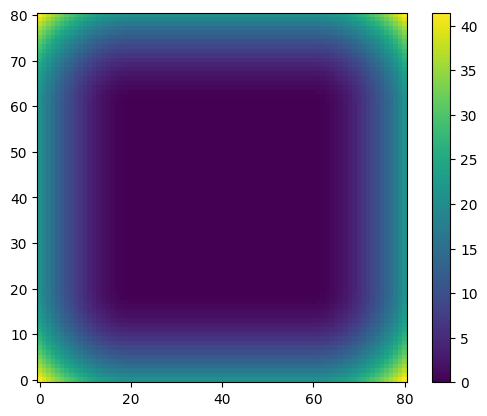

In [4]:
# plot sigma
plt.imshow(sigma,aspect="equal", interpolation='nearest')
plt.gca().invert_yaxis() # by default, imshow plots y to the bottom, and this inverts it
plt.colorbar()
plt.show()

Now we can integrate the differential equations. The continous versions (now with a source, an oscillator in the middle):

$$\frac{\partial v_x}{\partial t} = - \frac{\partial p}{\partial x} - \sigma_x(x) v_x$$
$$\frac{\partial v_y}{\partial t} = - \frac{\partial p}{\partial y} - \sigma_y(y) v_y$$
$$\frac{\partial p}{\partial t} = - \left( \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y} \right) - \left( \sigma_x(x) + \sigma_y(y) \right) p + S(x,y,t),$$

become now

$$v_x^{n+1/2}[i,j] = v_x^{n-1/2}[i,j] - \Delta t \left( \frac{p^n[i+1,j] - p^n[i,j]}{\Delta x} + \sigma_x[i] \cdot v_x^{n-1/2}[i,j] \right) $$
$$v_y^{n+1/2}[i,j] = v_y^{n-1/2}[i,j] - \Delta t \left( \frac{p^n[i,j+1] - p^n[i,j]}{\Delta y} + \sigma_y[j] \cdot v_y^{n-1/2}[i,j] \right) $$
$$p^{n+1}[i,j] = p^n[i,j] - \Delta t \left(
\frac{v_x^{n+1/2}[i,j] - v_x^{n+1/2}[i-1,j]}{\Delta x} +
\frac{v_y^{n+1/2}[i,j] - v_y^{n+1/2}[i,j-1]}{\Delta y} +
(\sigma_x[i] + \sigma_y[j]) \cdot p^n[i,j] \right) + S^n[i,j]$$


From ChatGPT:

Staggered means that different fields (e.g. pressure and velocity) are defined at offset grid positions in space and/or time. This improves numerical stability and accuracy in FDTD.

In 2D acoustics:

    Pressure p is defined at grid cell centres: (i,j)(i,j)

    Velocity v_x is defined at midpoints between pressure points in x: (i+1/2,j)

    Velocity v_y is defined at midpoints in y: (i,j+1/2)


This is often called a Yee grid (originally from electromagnetism) and avoids artificial oscillations.

In [5]:
# Precompute time series
t = np.arange(loops) * dt

# sources
ixs, iys = Nx // 6, Ny // 2 # source at a given position ( // meansinteger floor division)
accel = 2 * np.pi # avoid calculating it every time
#source_time = source_ampl * np.exp(-((t - t0)*f0)**2)  # Gaussian pulse
source_ampl = 10
source_time = source_ampl * np.sin(accel * t) # oscillator

# Initial pressure and velocities
p  = np.zeros((Nx+1, Ny+1), dtype=float)
vx = np.zeros((Nx, Ny+1), dtype=float)   # staggered in x
vy = np.zeros((Nx+1, Ny), dtype=float)   # staggered in y
#plt.plot(t,source_time)
print(dt,dx,dy)

0.025 0.05 0.05


In [6]:
fig, ax = plt.subplots()
im = ax.imshow(p, cmap='RdBu', vmin=-1, vmax=1, origin='lower', animated=True)

def update(frame):
    global p, vx, vy
    vx -= dt * ((p[1:, :] - p[:-1, :]) / dx + sigma_x[:-1, None] * vx)
    vy -= dt * ((p[:, 1:] - p[:, :-1]) / dy + sigma_y[None, :-1] * vy)
    p[1:-1,1:-1] -= dt * (
        (vx[1:,1:-1] - vx[:-1,1:-1]) / dx + (vy[1:-1,1:] - vy[1:-1,:-1]) / dy +
        (sigma[1:-1,1:-1] * p[1:-1,1:-1]))
    p[ixs, iys] += source_time[frame]  # source
    
    im.set_array(p)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=range(loops), blit=True)
ani.save("wave.mp4", writer="ffmpeg", fps=30)
display(Video("wave.mp4"))
plt.close('all')